**Preparing and Testing out Modality Data**

I'm looking at OSMnx walksheds to transit stops to see if I can somehow combine Metro data (stop maps and time schedules) with the OSMnx network. The purpose of this is to play around and find a methodolgy for creating transit sheds similar to our walksheds.

In [1]:
# setting up
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx

In [2]:
# configure the place, network type, trip times, and travel speed
# for the sake of this assignment using Echo Park
place = 'Echo Park, Los Angeles, CA, US'

# note for future self: Echo Park, Chinatown, Lincoln Heights how would I combine these with the Elysian Park boundaries
# mappable neighborhoods next to the park

network_type = 'walk' # walk drive or cycle options
trip_times = [5, 10] #in minutes
meters_per_minute = 75 # travel distance per minute

In [3]:
%%time
G = ox.graph_from_place(place, network_type=network_type)

CPU times: user 2.98 s, sys: 99.9 ms, total: 3.08 s
Wall time: 10.9 s


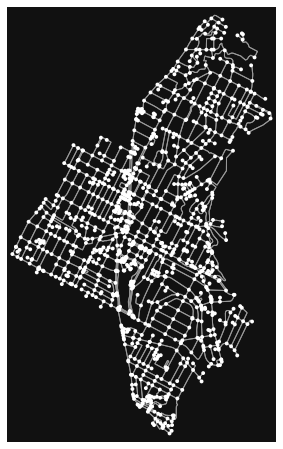

In [4]:
fig, ax = ox.plot_graph(G)

# Problem 1 Elysian Parks locations are not included in the network

In [30]:
G = ox.project_graph(G, to_crs='epsg:3857')

In [31]:
# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [32]:
# for now assume centroid method since the stops run along Echo Park Ave in the center of the neighborhood anyways
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13166172.755918913
4036684.5915200734
-13162830.299152251
4042056.956201715


In [33]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13164501.527535582
4039370.773860894


In [35]:
# get nearest node to centroid
center_node = ox.get_nearest_node(G,
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
print('ID for nearest node to centroid is ' + str(center_node))
gdf_nodes.loc[[center_node]]

ID for nearest node to centroid is 123236288


,y,x,osmid,lon,lat,highway,geometry
123236288,4.039403e+06,-1.316449e+07,123236288,-118.258634,34.07891,stop,POINT (-13164490.963 4039402.572)


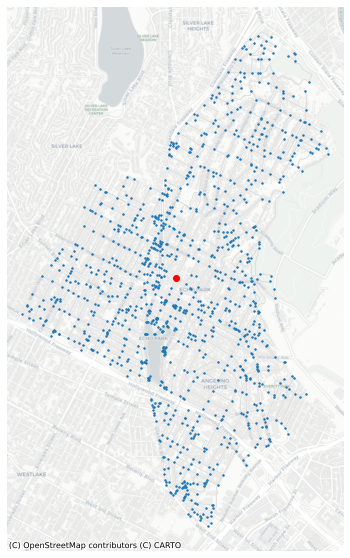

In [36]:
#subplot base

fig, ax = plt.subplots(figsize=(10,10))
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gainsboro', 
               zorder=10)
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

**Creating Isochrones**

In [37]:
# making walkshed isochrones
#calculation
# the main question is whether or not they reach the park edge

gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [38]:
# quick check because I went on without doing that and it's a little messy so checking again
gdf_edges[['osmid','name','highway','length','walk_time']].sample(5)

,osmid,name,highway,length,walk_time
2401,717093168,NaN,service,30.097,0.401293
2893,884985824,NaN,service,51.309,0.684120
1292,173553223,NaN,residential,99.770,1.330267
1254,398043316,Glendale Boulevard,primary,45.458,0.606107
1956,240890730,NaN,footway,384.784,5.130453


In [50]:
# assigning colors - tried terrain color didn't look good switching back to plasma
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap = 'plasma', start=0, return_hex=True)
print(trip_times)
print(iso_colors)

[10, 5]
['#0d0887', '#f0f921']


In [51]:
# oh! I forgot this the first run through and it resulted in not having the right values
# the not reversed actually might be preferable for this park in particular

trip_times.sort(reverse=True)

In [52]:
time_color=list(zip(trip_times,iso_colors))
time_color

[(10, '#0d0887'), (5, '#f0f921')]

In [53]:
for time, color in list(time_color):
    print('The color for '+str(time)+' minute is '+color)

The color for 10 minute is #0d0887
The color for 5 minute is #f0f921


In [54]:
#checking nodes
for time, color in list(time_color):

   #egograph
    subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color

There are 310 nodes within 10 minutes 
There are 75 nodes within 5 minutes 


In [55]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)

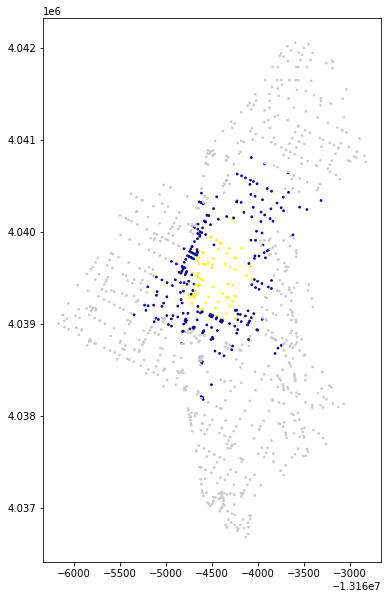

In [56]:
gdf_nodes.plot(figsize = (10,10), color = gdf_nodes['color'], markersize =3)

#why did some nodes get removed? oh the NaN nodes

In [57]:
# 5 minutes, are there none???
gdf_nodes[gdf_nodes['time']=='5 mins']

,y,x,osmid,lon,lat,highway,geometry,time,color
26468563,4.039530e+06,-1.316413e+07,26468563,-118.255387,34.079860,traffic_signals,POINT (-13164129.476 4039530.320),5 mins,#f0f921
26468564,4.039113e+06,-1.316435e+07,26468564,-118.257346,34.076758,traffic_signals,POINT (-13164347.562 4039113.399),5 mins,#f0f921
122604732,4.039629e+06,-1.316408e+07,122604732,-118.254924,34.080596,NaN,POINT (-13164077.890 4039629.308),5 mins,#f0f921
122604738,4.039722e+06,-1.316425e+07,122604738,-118.256502,34.081288,NaN,POINT (-13164253.608 4039722.181),5 mins,#f0f921
122604741,4.039768e+06,-1.316434e+07,122604741,-118.257283,34.081629,NaN,POINT (-13164340.537 4039768.120),5 mins,#f0f921
...,...,...,...,...,...,...,...,...,...
7404996336,4.039490e+06,-1.316462e+07,7404996336,-118.259794,34.079563,NaN,POINT (-13164620.061 4039490.403),5 mins,#f0f921
7404996340,4.039553e+06,-1.316465e+07,7404996340,-118.260064,34.080027,NaN,POINT (-13164650.061 4039552.792),5 mins,#f0f921
7457426759,4.039156e+06,-1.316461e+07,7457426759,-118.259706,34.077077,NaN,POINT (-13164610.264 4039156.299),5 mins,#f0f921
7457426760,4.039140e+06,-1.316462e+07,7457426760,-118.259779,34.076953,NaN,POINT (-13164618.402 4039139.661),5 mins,#f0f921


In [58]:
gdf_5=gdf_nodes[gdf_nodes['time']=='5 mins']

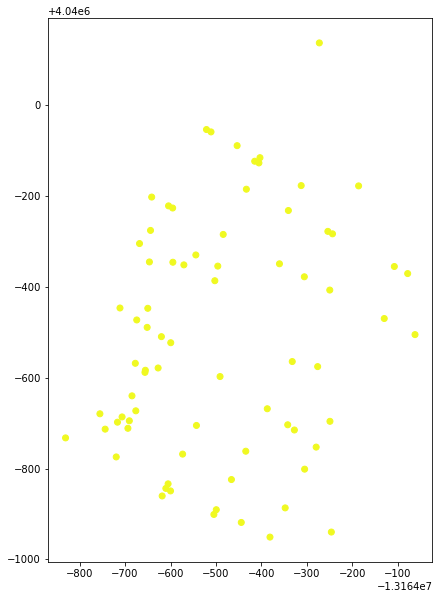

In [59]:
gdf_5.plot(figsize=(10,10), color = gdf_5.color)

#oh yeah it's empty what the heckin - I was using color palatte terrain which was white...

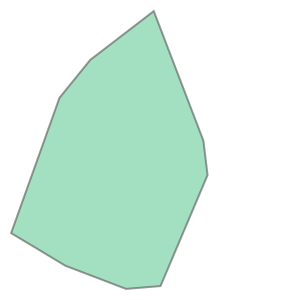

In [60]:
# creating a polygon
gdf_5.unary_union.convex_hull

In [61]:
# dissolve the nodes by time
isochrones = gdf_nodes.dissolve("time")
isochrones

,geometry,y,x,osmid,lon,lat,highway,color
time,,,,,,,,
10 mins,"MULTIPOINT (-13165349.559 4039101.935, -131652...",4.040330e+06,-1.316464e+07,14940281,-118.259983,34.085809,traffic_signals,#0d0887
5 mins,"MULTIPOINT (-13164831.111 4039267.514, -131647...",4.039530e+06,-1.316413e+07,26468563,-118.255387,34.079860,traffic_signals,#f0f921


In [62]:
isochrones = isochrones.convex_hull.reset_index()
isochrones

,time,0
0,10 mins,"POLYGON ((-13164597.663 4038181.447, -13165349..."
1,5 mins,"POLYGON ((-13164381.035 4039049.117, -13164618..."


In [63]:
isochrones.columns=['time','geometry']
isochrones.head()

,time,geometry
0,10 mins,"POLYGON ((-13164597.663 4038181.447, -13165349..."
1,5 mins,"POLYGON ((-13164381.035 4039049.117, -13164618..."


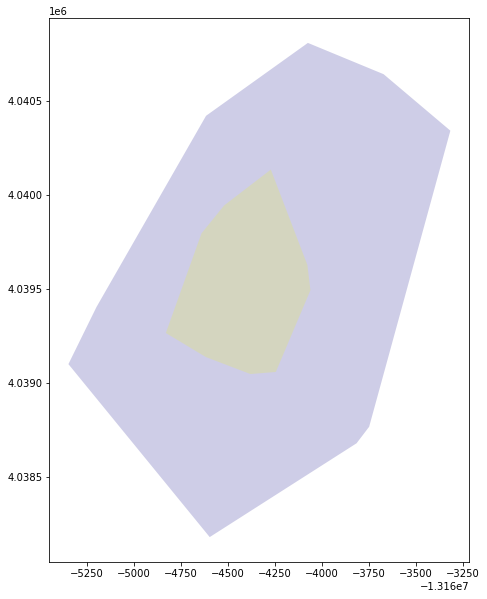

In [64]:
isochrones.plot(figsize=(10,10),alpha=0.2,cmap='plasma')

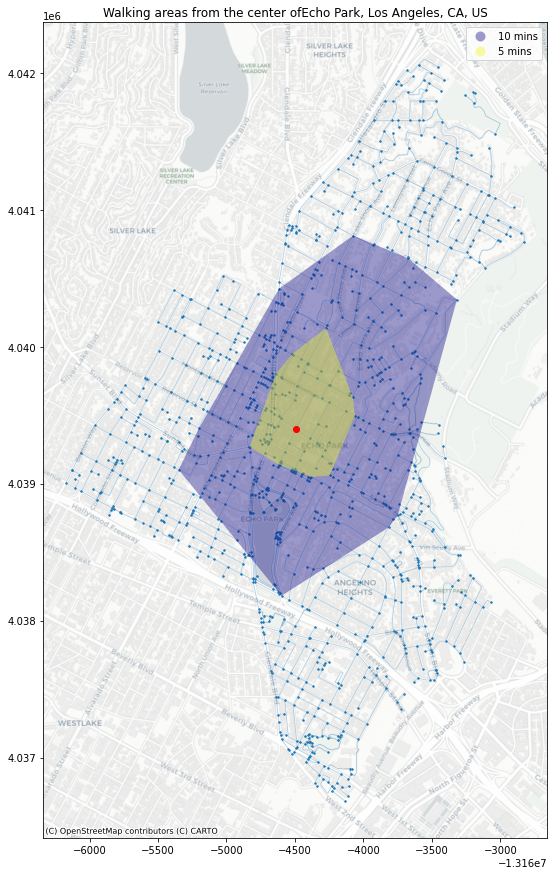

In [66]:
fix, ax = plt.subplots(figsize=(10,15))
isochrones.plot(alpha=0.4,ax=ax,column = 'time', cmap='plasma', legend = True, zorder=20)
gdf_nodes.loc[[center_node]].plot(ax=ax,color = 'r',zorder=30)
gdf_nodes.plot(ax=ax, markersize=2, zorder=10)
gdf_edges.plot(ax=ax, linewidth=0.75,alpha=0.2,zorder=10)
ax.axis('on')
ax.set_title('Walking areas from the center of' + place)

#basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

It is confirmed that the center of the Echo Park Community is within a 10 minute walking distance from the border of Elysian Park. This centroid is assumed to be near the bus stops along Echo Park Avenue in this neighborhood.

**Attempting to add in Transit Stops from Metro Shapefile**

I was unsuccesful in this endeavor and stopped around filtering through data.

In [71]:
metro_LSS = gpd.read_file('data/LineServingStops1219.shp')

In [77]:
#checking differences between the 2 data sets
metro_SSL = gpd.read_file('data/StopServingLines1219.shp')

In [73]:
metro_LSS.head()

,STOPNUM,LINE,DIR_A2,STOPNAME,LAT,LONG,geometry
0,1,108,E,PARAMOUNT / SLAUSON,33.973248,-118.113113,POINT (-118.11311 33.97325)
1,1,265,S,PARAMOUNT / SLAUSON,33.973248,-118.113113,POINT (-118.11311 33.97325)
2,3,35,N,JEFFERSON / 10TH,34.025471,-118.328402,POINT (-118.32840 34.02547)
3,6,55,N,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,POINT (-118.24222 33.92470)
4,6,120,W,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,POINT (-118.24222 33.92470)


In [78]:
metro_SSL.head()

,STOPNUM,STOPNAME,LAT,LONG,LINE_DIR_1,LINE_DIR_2,LINE_DIR_3,LINE_DIR_4,LINE_DIR_5,LINE_DIR_6,...,LINE_DIR_A,LINE_DIR_B,LINE_DIR_C,LINE_DIR_D,LINE_DIR_E,LINE_DIR_F,LINE_DIR_G,LINE_DIR_H,LINE_DIR_I,geometry
0,1,PARAMOUNT / SLAUSON,33.973248,-118.113113,108-E,265-S,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.11311 33.97325)
1,3,JEFFERSON / 10TH,34.025471,-118.328402,35-N,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.32840 34.02547)
2,6,120TH \ AUGUSTUS F HAWKINS,33.924696,-118.242222,55-N,120-W,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.24222 33.92470)
3,7,120TH \ MARTIN LUTHER KING HOSPITAL,33.924505,-118.240369,55-S,120-E,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.24037 33.92451)
4,8,120TH / CRENSHAW,33.923818,-118.326886,126-E,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-118.32689 33.92382)


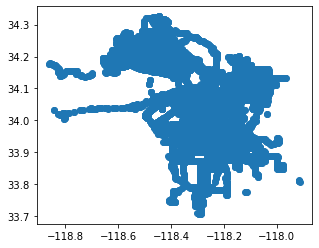

In [74]:
# looking at the data
metro_LSS.plot()

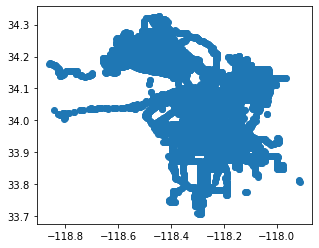

In [79]:
metro_SSL.plot()
# they look the same, but the data is organized differently?

It's difficult for me to discern which of these data sets have more pertinent information.

In [70]:
# filtering data for only Echo Park transit stops
metro_trimmed = [metro.STOPNAME.str.contains('ECHO PARK')]
metro_trimmed

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 19061    False
 19062    False
 19063    False
 19064    False
 19065    False
 Name: STOPNAME, Length: 19066, dtype: bool]